# Example calculation of PV potential for ERA5 data

I calculate for one year and derive monthly-mean values of PV potential. I compare two manners of parallelizing the work:

1. multiprocessing with 1 process per file, hence 12 processes; each process uses dask-xarray under the hood and can hence use >100% CPU
2. dask-xarray processing of 1 dataset with all 12 months

In [1]:
import xarray as xr
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from multiprocessing import Process, Queue

import core as core

import warnings
warnings.filterwarnings("ignore")

In [2]:
# location of era5 data on teachinghub
path="/home/harshitl69/LEHRE/msc-intro-comp-met-ex-w2024/data/era5/"

## 1. Multiprocessing

In [3]:
# generate list of era5 files for a given year
def get_filelists(year: str):
    flist = list()
    for file in Path(path).rglob("era5-"+year+"-*.nc"):
        flist.append(file)
    return flist

In [4]:
# function to compute time-mean pv potential, will be called by multiprocessing
def batchcompute_pvpot(file, queue):
    ds = xr.open_dataset(file, engine="netcdf4", chunks={"valid_time":1e5} )
    ds["wspd"] = core.windspeed(ds)
    pv_pot = core.pv_pot(ds).mean("valid_time").compute()
    queue.put(pv_pot)
    return None

In [5]:
def main(year, client):
    path="/home/yannickh00/LEHRE/msc-intro-comp-met-ex-w2024/data/era5/"    
    print
    # open the dataset
    ds=xr.open_mfdataset(path+f"era5-{year}-*.nc", engine="netcdf4", chunks={"valid_time":1e5} )
    
    # calculate the windsped
    ds["wspd"] = mf.calc_ws(ds)
    # calculate the pv potential and group it by months
    print("Calculating pv mean")
    pvpot = mf.calc_pv_pot(ds).groupby(ds.valid_time.dt.month).mean("valid_time").compute()

    # shutdown the client
    client.shutdown()
    return pvpot

In [6]:
nlat = 721;
nlon = 1440;

def multi_processing():
    year= "2000"
    flist = get_filelists(year)
    # use 1 process per monthly file
    nprocs = len(flist)
    # output from each process
    pvpot_chk = np.zeros((nprocs,nlat,nlon))
    queue = Queue()
    processes = [Process(target=batchcompute_pvpot, 
                         args=(flist[i], queue)) for i in range(0, nprocs)]
    for process in processes: process.start() # start all processes
    for i in range(nprocs): # collect results from processes
        pvpot_chk[i] = queue.get()
    for process in processes: process.join()  # wait for all processes to complete
    # merge into yearly array
    pvpot = np.stack(pvpot_chk, axis=0)

In [7]:
core.measure_performance(multi_processing)

Execution time: 168.45766 seconds


## 2. Dask-array on merged file

In [8]:
def dask_xarray():
    ds2=xr.open_mfdataset(path+"era5-2000-*.nc", chunks={"valid_time":1e5} )
    ds2["wspd"] = core.windspeed(ds2)
    pvpot2 = core.pv_pot(ds2).groupby(ds2.valid_time.dt.month).mean("valid_time").compute()

In [9]:
core.measure_performance(dask_xarray)

Execution time: 699.43940 seconds


In [11]:
from pathlib import Path

path="/home/harshitl69/LEHRE/msc-intro-comp-met-ex-w2024/data/era5/"
year = "2000"
file_list = list(Path(path).rglob(f"era5-{year}-*.nc"))
print(file_list)  # This will print out the list of files it finds


[PosixPath('/home/harshitl69/LEHRE/msc-intro-comp-met-ex-w2024/data/era5/era5-2000-01.nc'), PosixPath('/home/harshitl69/LEHRE/msc-intro-comp-met-ex-w2024/data/era5/era5-2000-02.nc'), PosixPath('/home/harshitl69/LEHRE/msc-intro-comp-met-ex-w2024/data/era5/era5-2000-03.nc'), PosixPath('/home/harshitl69/LEHRE/msc-intro-comp-met-ex-w2024/data/era5/era5-2000-04.nc'), PosixPath('/home/harshitl69/LEHRE/msc-intro-comp-met-ex-w2024/data/era5/era5-2000-05.nc'), PosixPath('/home/harshitl69/LEHRE/msc-intro-comp-met-ex-w2024/data/era5/era5-2000-06.nc'), PosixPath('/home/harshitl69/LEHRE/msc-intro-comp-met-ex-w2024/data/era5/era5-2000-07.nc'), PosixPath('/home/harshitl69/LEHRE/msc-intro-comp-met-ex-w2024/data/era5/era5-2000-08.nc'), PosixPath('/home/harshitl69/LEHRE/msc-intro-comp-met-ex-w2024/data/era5/era5-2000-09.nc'), PosixPath('/home/harshitl69/LEHRE/msc-intro-comp-met-ex-w2024/data/era5/era5-2000-10.nc'), PosixPath('/home/harshitl69/LEHRE/msc-intro-comp-met-ex-w2024/data/era5/era5-2000-11.nc')

In [12]:
import xarray as xr
import core  # Ensure this contains the necessary functions: windspeed and pv_pot

# Correcting the file path and data processing
file_path = '/home/harshitl69/LEHRE/msc-intro-comp-met-ex-w2024/data/era5/era5-2000-01.nc'
ds = xr.open_dataset(file_path)
ds['wspd'] = core.windspeed(ds)
ds['pv_pot'] = core.pv_pot(ds)

# Using the correct dimension name for averaging
monthly_mean = ds.mean('valid_time').compute()  # Replacing 'time' with 'valid_time'
print(monthly_mean)


<xarray.Dataset> Size: 29MB
Dimensions:    (latitude: 721, longitude: 1440)
Coordinates:
    number     int64 8B 0
  * latitude   (latitude) float64 6kB 90.0 89.75 89.5 ... -89.5 -89.75 -90.0
  * longitude  (longitude) float64 12kB 0.0 0.25 0.5 0.75 ... 359.2 359.5 359.8
Data variables:
    t2m        (latitude, longitude) float32 4MB 249.5 249.5 ... 243.8 243.8
    ssrd       (latitude, longitude) float32 4MB 0.0 0.0 ... 1.416e+06 1.416e+06
    ssrdc      (latitude, longitude) float32 4MB 0.0 0.0 ... 1.509e+06 1.509e+06
    u10        (latitude, longitude) float32 4MB -0.1134 -0.1134 ... 0.426 0.426
    v10        (latitude, longitude) float32 4MB -0.001188 -0.001188 ... 0.06342
    wspd       (latitude, longitude) float32 4MB 0.3141 0.3141 ... 0.4577 0.4577
    pv_pot     (latitude, longitude) float32 4MB 0.0 0.0 0.0 ... 0.4679 0.4679


In [14]:
pv_pot_mean = ds['pv_pot'].mean('valid_time')
pv_pot_slice = ds['pv_pot'].isel(valid_time=0)


In [24]:
import xarray as xr

def extract_europe(ds):
    print("Slicing latitude from 35 to 71 degrees North.")
    print("Available latitudes: ", ds.latitude.values)

    # Define latitude and longitude bounds for Europe
    lat_bounds = (35, 71)  # Bounds for Europe
    lon_bounds = (335, 360, 0, 40)  # Adjusted for 0-360 longitude system

    # Handling longitude slices (wrapping around the meridian at 0 degree)
    european_subset_1 = ds.sel(latitude=slice(71, 35), longitude=slice(335, 360))
    european_subset_2 = ds.sel(latitude=slice(71, 35), longitude=slice(0, 40))

    # Combine the two longitude segments
    european_subset = xr.concat([european_subset_1, european_subset_2], dim='longitude')

    # Debug: Print the result dimensions and sizes
    print("Resulting subset dimensions: ", european_subset.dims)
    print("Resulting subset sizes: ", european_subset.sizes)

    return european_subset

# Assuming `ds` is correctly loaded with data
european_data = extract_europe(ds)
print(european_data)


Slicing latitude from 35 to 71 degrees North.
Available latitudes:  [ 90.    89.75  89.5   89.25  89.    88.75  88.5   88.25  88.    87.75
  87.5   87.25  87.    86.75  86.5   86.25  86.    85.75  85.5   85.25
  85.    84.75  84.5   84.25  84.    83.75  83.5   83.25  83.    82.75
  82.5   82.25  82.    81.75  81.5   81.25  81.    80.75  80.5   80.25
  80.    79.75  79.5   79.25  79.    78.75  78.5   78.25  78.    77.75
  77.5   77.25  77.    76.75  76.5   76.25  76.    75.75  75.5   75.25
  75.    74.75  74.5   74.25  74.    73.75  73.5   73.25  73.    72.75
  72.5   72.25  72.    71.75  71.5   71.25  71.    70.75  70.5   70.25
  70.    69.75  69.5   69.25  69.    68.75  68.5   68.25  68.    67.75
  67.5   67.25  67.    66.75  66.5   66.25  66.    65.75  65.5   65.25
  65.    64.75  64.5   64.25  64.    63.75  63.5   63.25  63.    62.75
  62.5   62.25  62.    61.75  61.5   61.25  61.    60.75  60.5   60.25
  60.    59.75  59.5   59.25  59.    58.75  58.5   58.25  58.    57.75
  57.5   

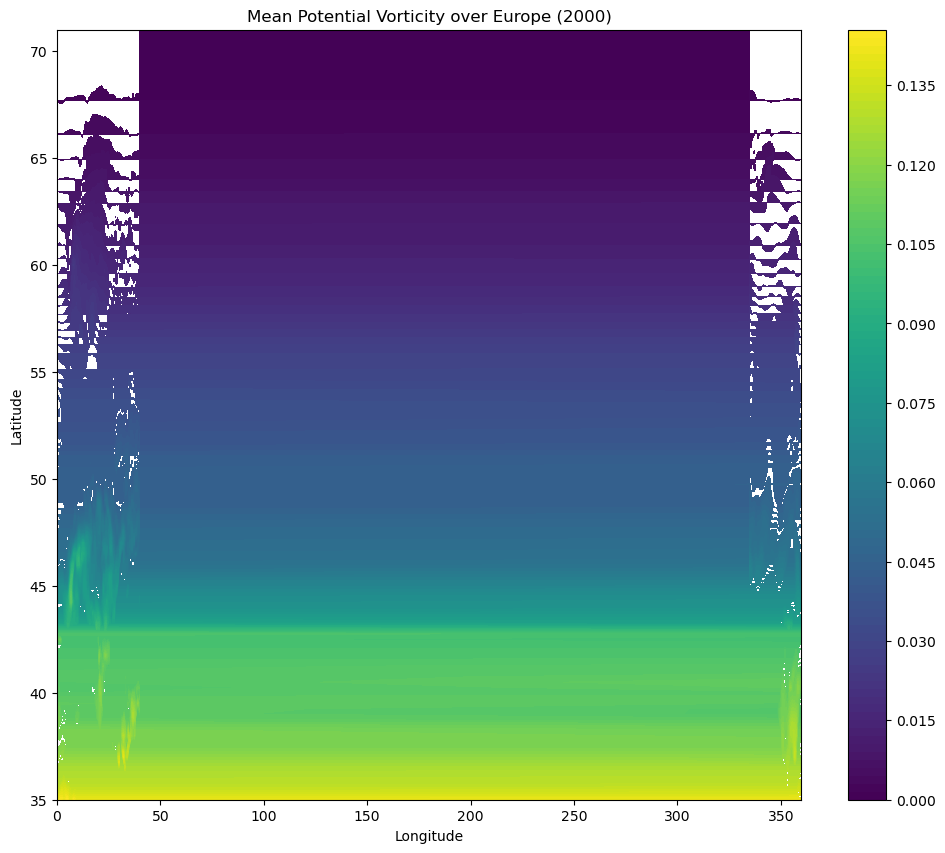

In [26]:
import matplotlib.pyplot as plt

# Assuming `pv_pot_tmean` is the mean of potential vorticity across time,
# or you can calculate it if not already done:
pv_pot_tmean = european_data['pv_pot'].mean(dim='valid_time')

# Create a filled contour plot with a colorbar
plt.figure(figsize=(12, 10))
contourf = plt.contourf(european_data.longitude, european_data.latitude, pv_pot_tmean, cmap='viridis', levels=100)
plt.colorbar(contourf)
plt.title('Mean Potential Vorticity over Europe (2000)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()


In [25]:
import xarray as xr
import core  # Ensure this module has the necessary functions: windspeed and pv_pot

# Define the base path and the year of interest
base_path = '/home/harshitl69/LEHRE/msc-intro-comp-met-ex-w2024/data/era5/'
year = 2000

# Loop through each month, process the file, and print the pv_pot mean
for month in range(1, 13):  # Loop from January (1) to December (12)
    # Format the filename for each month
    file_path = f"{base_path}era5-{year}-{month:02d}.nc"
    
    try:
        # Open the dataset
        ds = xr.open_dataset(file_path)
        
        # Calculate windspeed and pv_pot
        ds['wspd'] = core.windspeed(ds)
        ds['pv_pot'] = core.pv_pot(ds)
        
        # Calculate the monthly mean of pv_pot
        monthly_mean_pv_pot = ds['pv_pot'].mean(dim='valid_time').compute()
        
        # Print the monthly mean pv_pot
        print(f"Monthly mean PV Pot for {year}-{month:02d}:")
        print(monthly_mean_pv_pot)
        print()  # Print a newline for better separation between months

    except Exception as e:
        print(f"Failed to process file for {year}-{month:02d}: {e}")


Monthly mean PV Pot for 2000-01:
<xarray.DataArray 'pv_pot' (latitude: 721, longitude: 1440)> Size: 4MB
array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.48196262, 0.48198524, 0.4820098 , ..., 0.48184314, 0.48187613,
        0.4819154 ],
       [0.4816251 , 0.48164183, 0.48165774, ..., 0.4815678 , 0.48158753,
        0.4816064 ],
       [0.4679344 , 0.4679344 , 0.4679344 , ..., 0.4679344 , 0.4679344 ,
        0.4679344 ]], dtype=float32)
Coordinates:
    number     int64 8B 0
  * latitude   (latitude) float64 6kB 90.0 89.75 89.5 ... -89.5 -89.75 -90.0
  * longitude  (longitude) float64 12kB 0.0 0.25 0.5 0.75 ... 359.2 359.5 359.8

Monthly mean PV Pot for 2000-02:
<xarray.DataArray 'pv_pot' (latitude: 721, longitude: 1440)> Size: 4MB
arr

In [25]:
import xarray as xr
import core  # Ensure this module has the necessary functions: windspeed and pv_pot

# Define the base path and the year of interest
base_path = '/home/harshitl69/LEHRE/msc-intro-comp-met-ex-w2024/data/era5/'
year = 2000

# Loop through each month, process the file, and print the pv_pot mean
for month in range(1, 13):  # Loop from January (1) to December (12)
    # Format the filename for each month
    file_path = f"{base_path}era5-{year}-{month:02d}.nc"
    
    try:
        # Open the dataset
        ds = xr.open_dataset(file_path)
        
        # Calculate windspeed and pv_pot
        ds['wspd'] = core.windspeed(ds)
        ds['pv_pot'] = core.pv_pot(ds)
        
        # Calculate the monthly mean of pv_pot
        monthly_mean_pv_pot = ds['pv_pot'].mean(dim='valid_time').compute()
        
        # Print the monthly mean pv_pot
        print(f"Monthly mean PV Pot for {year}-{month:02d}:")
        print(monthly_mean_pv_pot)
        print()  # Print a newline for better separation between months

    except Exception as e:
        print(f"Failed to process file for {year}-{month:02d}: {e}")


Monthly mean PV Pot for 2000-01:
<xarray.DataArray 'pv_pot' (latitude: 721, longitude: 1440)> Size: 4MB
array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.48196262, 0.48198524, 0.4820098 , ..., 0.48184314, 0.48187613,
        0.4819154 ],
       [0.4816251 , 0.48164183, 0.48165774, ..., 0.4815678 , 0.48158753,
        0.4816064 ],
       [0.4679344 , 0.4679344 , 0.4679344 , ..., 0.4679344 , 0.4679344 ,
        0.4679344 ]], dtype=float32)
Coordinates:
    number     int64 8B 0
  * latitude   (latitude) float64 6kB 90.0 89.75 89.5 ... -89.5 -89.75 -90.0
  * longitude  (longitude) float64 12kB 0.0 0.25 0.5 0.75 ... 359.2 359.5 359.8

Monthly mean PV Pot for 2000-02:
<xarray.DataArray 'pv_pot' (latitude: 721, longitude: 1440)> Size: 4MB
arr

In [28]:
import xarray as xr
import multiprocessing
import core  # Ensure this module has the necessary functions: windspeed and pv_pot

def extract_europe(ds):
    # Define latitude and longitude bounds for Europe
    lat_bounds = (35, 71)  # Bounds for Europe
    lon_bounds = ((335, 360), (0, 40))  # Adjusted for 0-360 longitude system

    # Handling longitude slices (wrapping around the meridian at 0 degree)
    european_subset_1 = ds.sel(latitude=slice(71, 35), longitude=slice(335, 360))
    european_subset_2 = ds.sel(latitude=slice(71, 35), longitude=slice(0, 40))

    # Combine the two longitude segments
    european_subset = xr.concat([european_subset_1, european_subset_2], dim='longitude')
    return european_subset

def process_month(month):
    base_path = '/home/harshitl69/LEHRE/msc-intro-comp-met-ex-w2024/data/era5/'
    year = 2000
    file_path = f"{base_path}era5-{year}-{month:02d}.nc"
    
    try:
        ds = xr.open_dataset(file_path)
        # Filter dataset for Europe before processing further
        ds = extract_europe(ds)
        ds['wspd'] = core.windspeed(ds)
        ds['pv_pot'] = core.pv_pot(ds)
        monthly_mean_pv_pot = ds['pv_pot'].mean(dim='valid_time').compute()
        return f"Monthly mean PV Pot for {year}-{month:02d} over Europe: {monthly_mean_pv_pot.values}"
    except Exception as e:
        return f"Failed to process file for {year}-{month:02d}: {e}"

if __name__ == '__main__':
    months = range(1, 13)  # January (1) to December (12)
    pool = multiprocessing.Pool(processes=4)  # Adjust number of processes based on your system
    results = pool.map(process_month, months)
    pool.close()
    pool.join()
    
    for result in results:
        print(result)
        print()  # Print a newline for better separation between results


Monthly mean PV Pot for 2000-01 over Europe: [[1.42950579e-04 1.39991156e-04 1.42475925e-04 ... 6.75156698e-05
  6.75612973e-05 6.76651835e-05]
 [2.02683732e-04 1.98823152e-04 2.02569674e-04 ... 9.68383974e-05
  9.69740868e-05 9.68983659e-05]
 [2.68040894e-04 2.68294039e-04 2.64814822e-04 ... 1.32858942e-04
  1.33015521e-04 1.33031004e-04]
 ...
 [1.02328010e-01 1.01959333e-01 1.01442382e-01 ... 1.29403397e-01
  1.28071114e-01 1.26006767e-01]
 [1.04048379e-01 1.03199013e-01 1.02500923e-01 ... 1.32411644e-01
  1.31924540e-01 1.30953148e-01]
 [1.05705097e-01 1.04695804e-01 1.03961036e-01 ... 1.35784850e-01
  1.35352746e-01 1.34982660e-01]]

Monthly mean PV Pot for 2000-02 over Europe: [[0.01514313 0.01489929 0.01499907 ... 0.01168691 0.01155437 0.01142243]
 [0.0156491  0.01531411 0.01542651 ... 0.01207118 0.01196909 0.01186896]
 [0.01594522 0.01585235 0.01565384 ... 0.0125412  0.01245263 0.01234956]
 ...
 [0.14198074 0.14268169 0.14329799 ... 0.18040265 0.18007845 0.17843091]
 [0.14357205

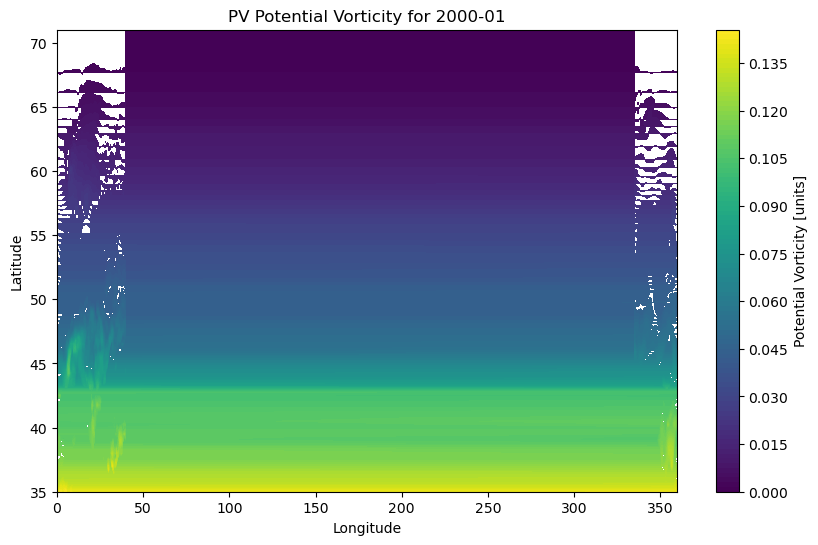

Processed and plotted for 2000-01


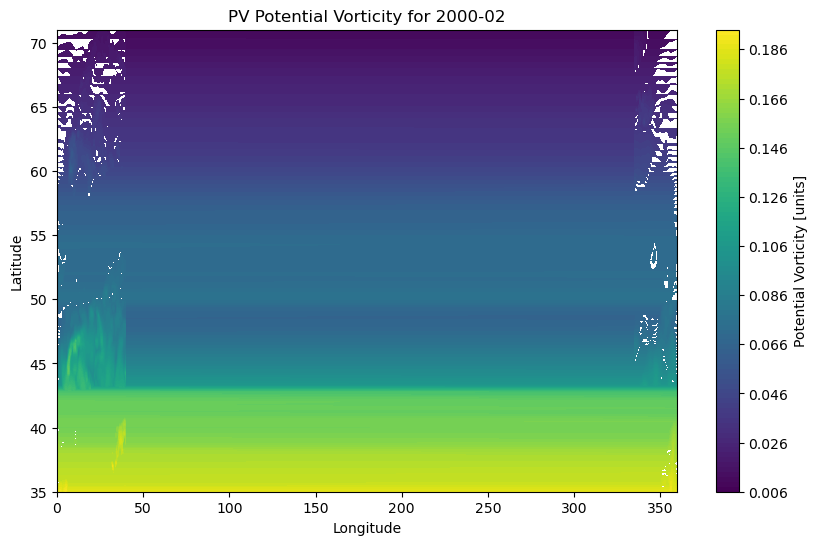

Processed and plotted for 2000-02


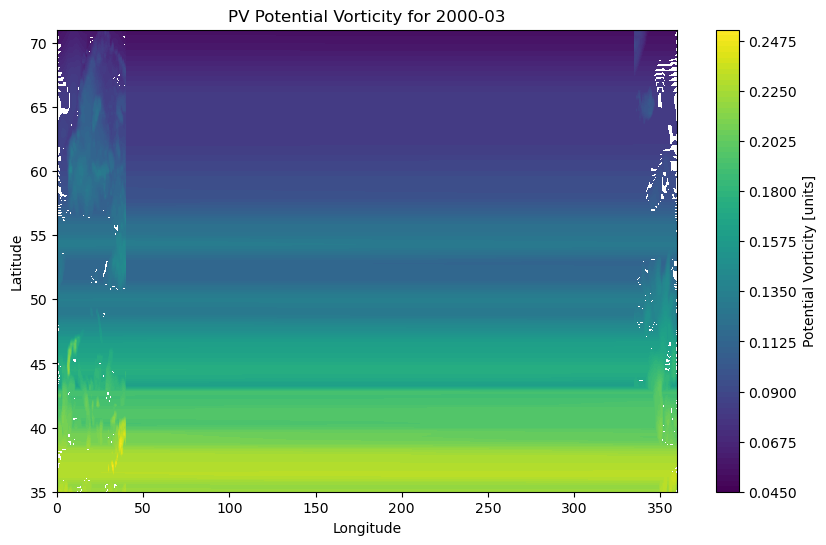

Processed and plotted for 2000-03


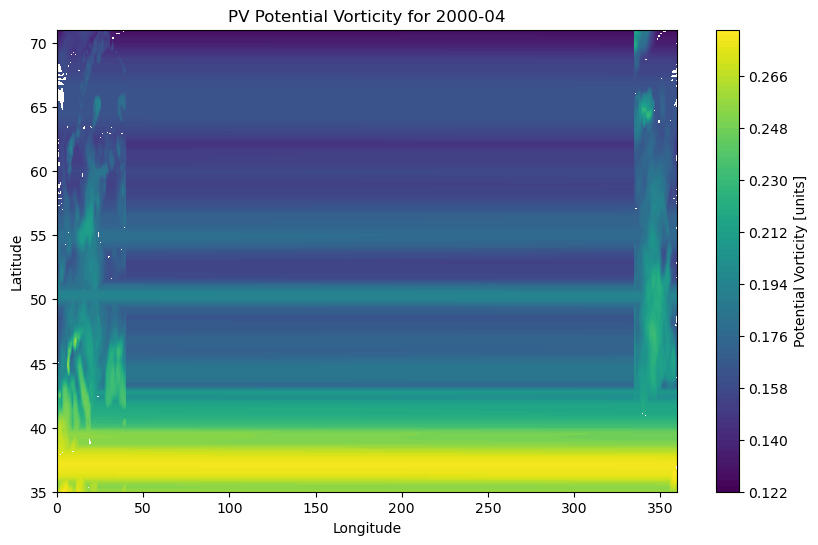

Processed and plotted for 2000-04


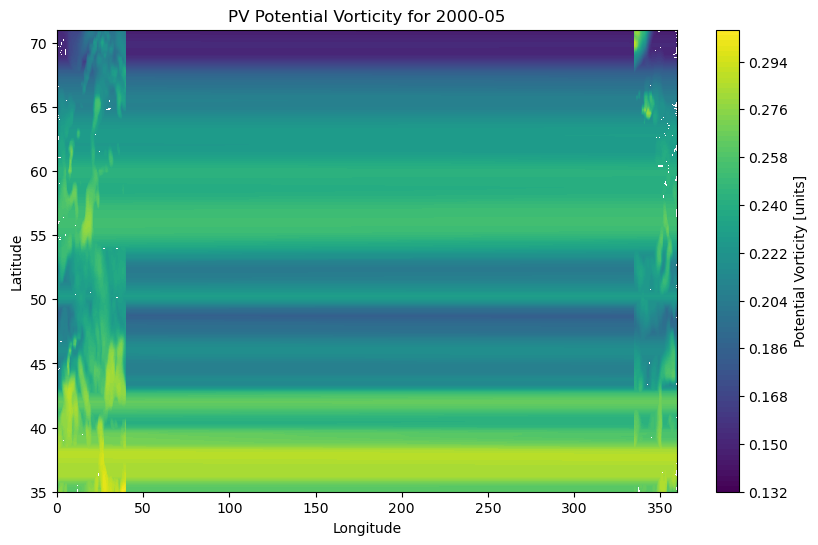

Processed and plotted for 2000-05


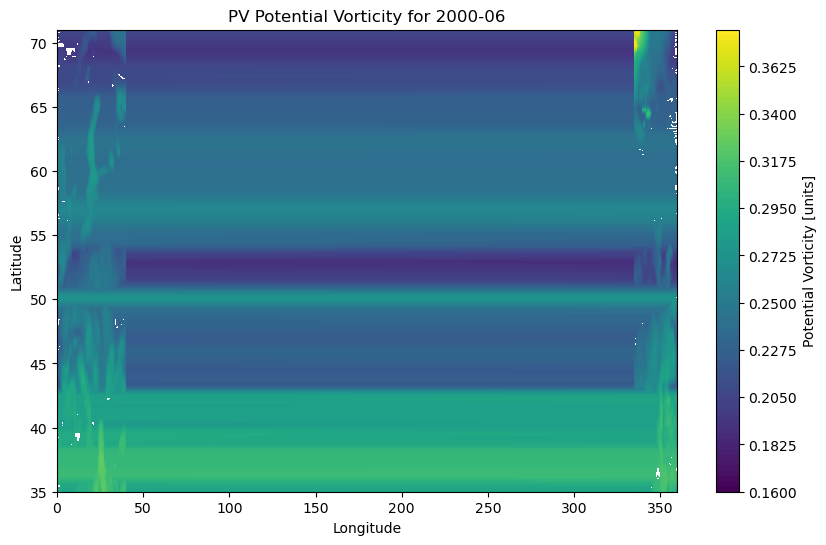

Processed and plotted for 2000-06


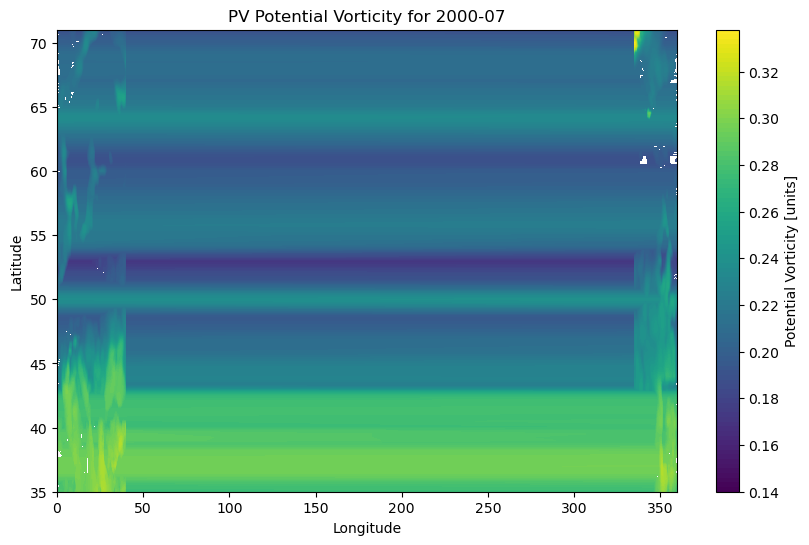

Processed and plotted for 2000-07


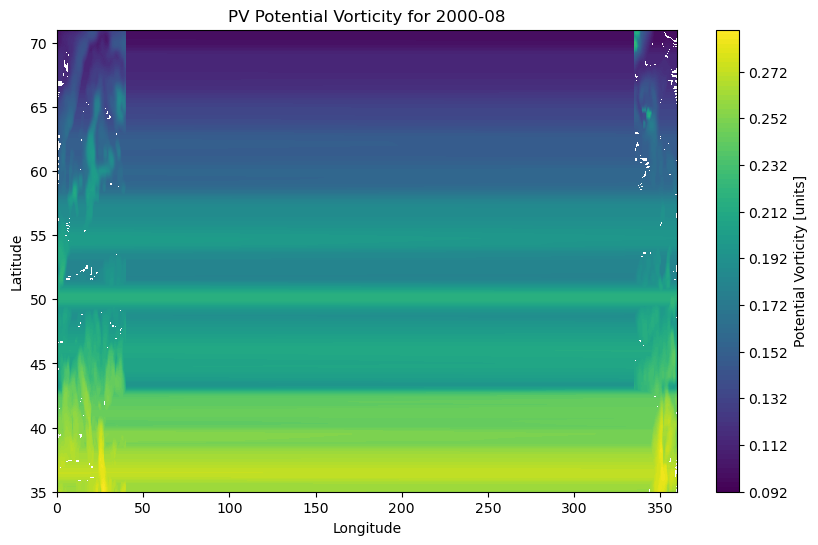

Processed and plotted for 2000-08


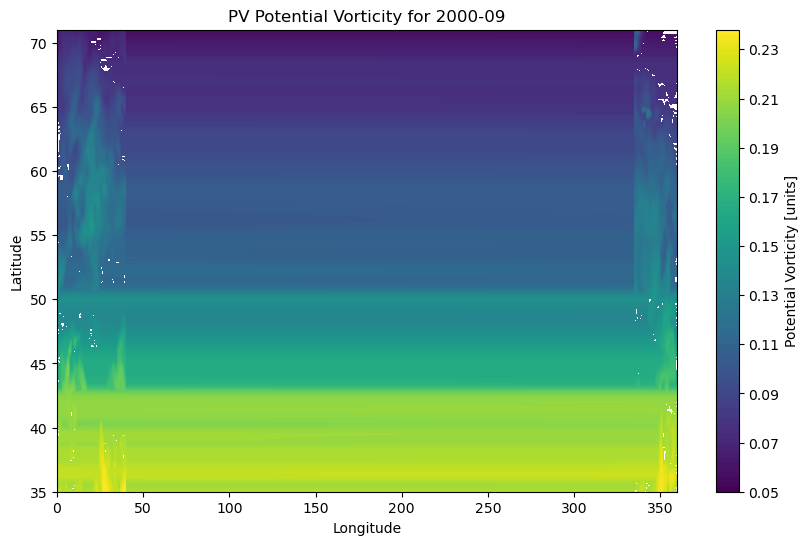

Processed and plotted for 2000-09


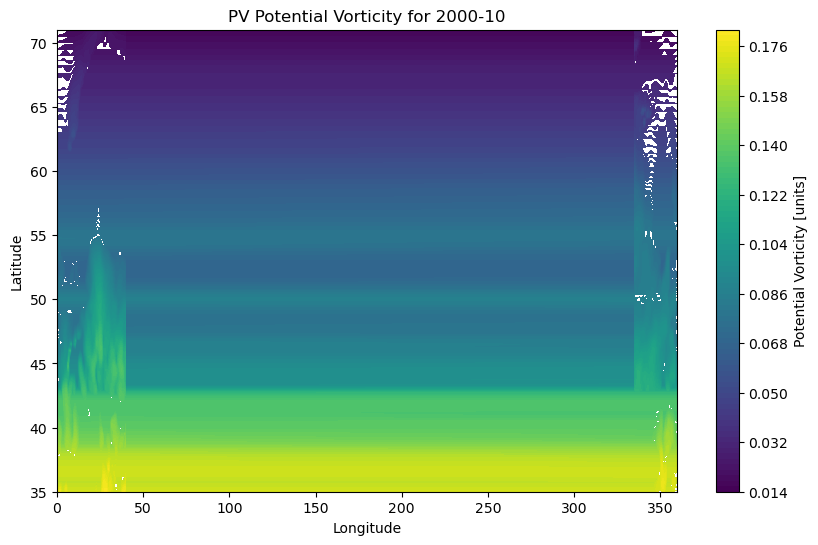

Processed and plotted for 2000-10


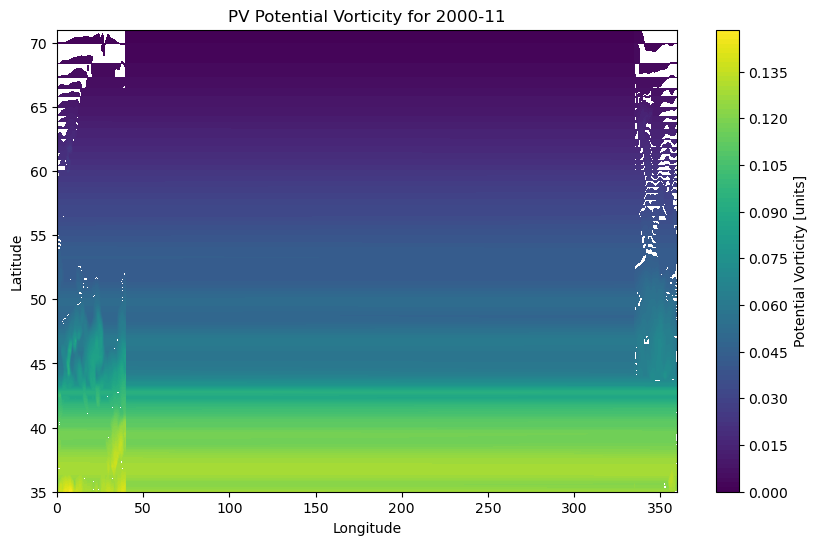

Processed and plotted for 2000-11


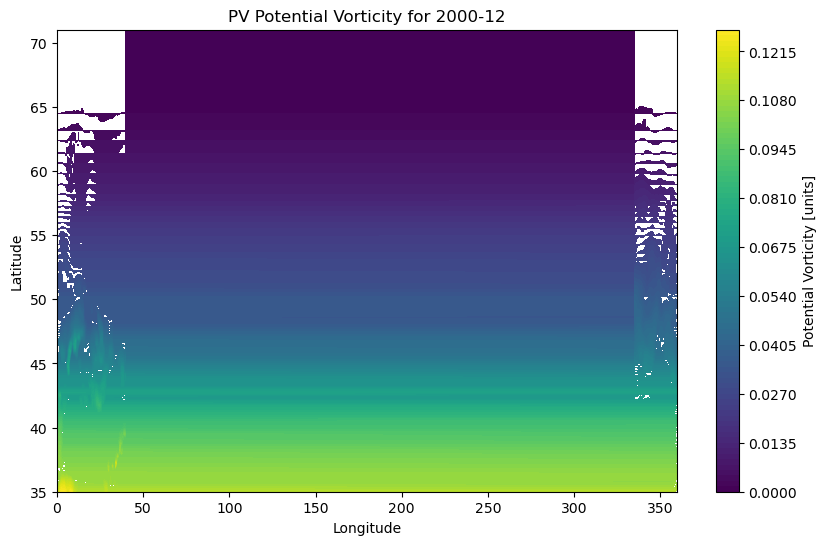

Processed and plotted for 2000-12


In [2]:
import xarray as xr
import matplotlib.pyplot as plt
import core  # Ensure this module has the necessary functions: windspeed and pv_pot

def extract_europe(ds):
    # Define latitude and longitude bounds for Europe
    lat_bounds = (35, 71)  # Bounds for Europe
    lon_bounds = ((335, 360), (0, 40))  # Adjusted for 0-360 longitude system

    # Handling longitude slices (wrapping around the meridian at 0 degree)
    european_subset_1 = ds.sel(latitude=slice(71, 35), longitude=slice(335, 360))
    european_subset_2 = ds.sel(latitude=slice(71, 35), longitude=slice(0, 40))

    # Combine the two longitude segments
    european_subset = xr.concat([european_subset_1, european_subset_2], dim='longitude')
    return european_subset

def plot_monthly_pv_pot(data, month, year=2000):
    plt.figure(figsize=(10, 6))
    plt.contourf(data.longitude, data.latitude, data, levels=100, cmap='viridis')
    plt.title(f'PV Potential Vorticity for {year}-{month:02d}')
    plt.colorbar(label='Potential Vorticity [units]')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.savefig(f'PV_Pot_2000_{month:02d}.png')  # Save each plot as a PNG
    plt.show()

def process_month(month):
    base_path = '/home/harshitl69/LEHRE/msc-intro-comp-met-ex-w2024/data/era5/'
    year = 2000
    file_path = f"{base_path}era5-{year}-{month:02d}.nc"
    
    try:
        ds = xr.open_dataset(file_path)
        ds = extract_europe(ds)
        ds['wspd'] = core.windspeed(ds)
        ds['pv_pot'] = core.pv_pot(ds)
        monthly_mean_pv_pot = ds['pv_pot'].mean(dim='valid_time').compute()
        
        # Plot directly in the notebook
        plot_monthly_pv_pot(monthly_mean_pv_pot, month)
        
        return f"Processed and plotted for {year}-{month:02d}"
    except Exception as e:
        return f"Failed to process file for {year}-{month:02d}: {e}"

# Running the processing sequentially (example for a few months due to performance considerations in a notebook)
for month in range(1, 13):
    print(process_month(month))


In [3]:
import imageio

def create_gif(image_path_pattern, gif_path, duration=0.5):
    images = []
    for month in range(1, 13):
        image_filename = image_path_pattern.format(month)
        images.append(imageio.imread(image_filename))
    imageio.mimsave(gif_path, images, duration=duration)

# Call the function with the path to your saved images
create_gif('PV_Pot_2000_{:02d}.png', 'PV_Pot_2000.gif')




/tmp/ipykernel_715909/590515069.py:7: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(image_filename))


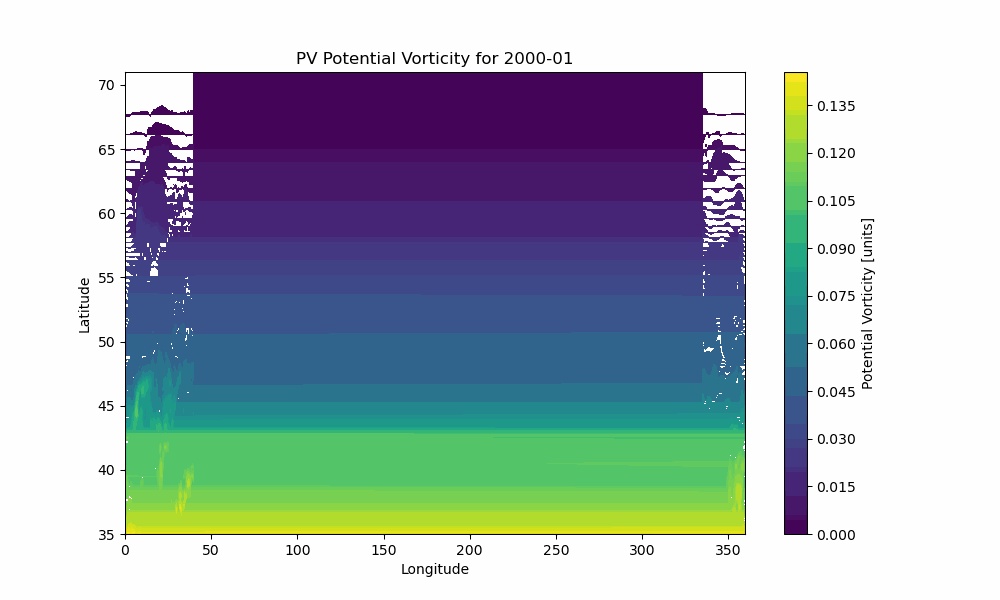

In [4]:
from IPython.display import Image
Image(filename='PV_Pot_2000.gif')
